# Team Introduction
Our group is comprised of Braden Anderson, Hien Lam, and Tavin Weeda.

In [2]:
# testing testing testing delete later

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from lightgbm import LGBMClassifier
from scipy import stats

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Data Preparation Part 1
- Define and prepare your class variables. 
- Use proper variable representations (int, float, one-hot, etc.). 
- Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. 
- Remove variables that are not needed/useful for the analysis.
(10)

## Section Summary:
1. Read, merged, filtered the data then dealt with missing values
2. Inspected each feature, noted cleaning steps if necessary (features from lab 1 only)
3. Carefully binned existing features (`speeding_status`, `hour_binned`, `body_type_binned`, `intersection_binned`, `weather_binned`)
4. Derived new features (`restraint_binned`, `pcrash1_imname`)
5. Binned and visualized response variable for classification task, `maxsev_binned`
6. Visualized response variable for regression task, `age_im`
7. Confirmed there are zero duplicates and NA values
8. Conducted data preprocessing: 
  - Split train/test data to 80/20% with 10 fold stratified cross validation
  - Scaled `age_im`
  - Hot encoded features on train and test data separately
  - Imputed and scaled `trav_sp` 
9. Removed variables that were not needed/useful: 
  - `makename` (too many levels), 
  - `wrk_zonename` (99% of one class)
  - `hour_imname` (unnecessary with `hour_binned`)
  - `vspd_lim` (unnecessary with `speeding_status`) 
  - `body_type_x` (unnecessary with `body_type_binned`)
  - `weathername` (unecessary with `weather_binned`)
  - `typ_intname` (unnecessary with `intersection_binned`)
  - `maxsev_imname` (unnecessary with `maxsev_binned`)
  - `trav_sp` (unnecessary with `trav_sp_imputed`)
10. Table of proper variable representation
11. Performed three feature selection techniques: Random Forest, SelectKBest, Mutual Information

## Read, clean the data

In [2]:
# Read in data from github
url_accident = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/accident.csv.gz?raw=tr"
url_vehicle = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/vehicle.csv.gz?raw=tr"
url_person = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/person.csv.gz?raw=tr"

accident = pd.read_csv(url_accident,compression='gzip')
vehicle = pd.read_csv(url_vehicle, compression='gzip', low_memory=False, encoding="ISO-8859-1")
person = pd.read_csv(url_person, compression='gzip', low_memory=False, encoding="ISO-8859-1")

In [3]:
# Filter accidents where driver is present and vehicle is involved
person = person.loc[(person.VEH_NO==1) & (person.PER_NO==1)]
vehicle = vehicle.loc[vehicle.VEH_NO==1]

In [4]:
# Left join person with vehicle and accident
# Duplicated CASENUM are dropped
df = person.merge(vehicle.drop_duplicates(subset=['CASENUM']), on='CASENUM', how='left')
df = df.merge(accident.drop_duplicates(subset=['CASENUM']),on='CASENUM',how='left')

In [5]:
# Comprehensive list of variables used in this analysis
# ORIGINAL features from lab 1 / EDA: regionname, urbanicityname, body_typname, makename, mod_yearname, vtrafwayname, vnum_lanname, vsurcondname, vtrafconname, 
                                # typ_intname, int_hwyname, weathername, wkdy_imname, reljct1_imname, lgtcon_imname, maxsev_imname, alchl_imname, age_im, sex_imname, trav_sp
# DERIVED features: hour_binned, speeding_status
# NEW features post-lab 1 / EDA: rest_usename, pcrash1_imname, weather_binned (binning of `weathername`), body_type_binned (binning of `body_typname`), int_binned (binning of `typ_intname`)
# DISCARDED features that were not useful: hour_imname (unnecessary with `hour_binned`), vspd_lim (unnecessary with `speeding_status`), makename (too many levels), wrk_zonename

df = df[['REGIONNAME','URBANICITYNAME','BODY_TYPNAME_x', 'MOD_YEARNAME_x','VTRAFWAYNAME','VNUM_LANNAME','VSURCONDNAME','VTRAFCONNAME','TYP_INTNAME','INT_HWYNAME','WEATHERNAME',
        'WKDY_IMNAME', 'RELJCT1_IMNAME','LGTCON_IMNAME','MAXSEV_IMNAME','ALCHL_IMNAME','AGE_IM','SEX_IMNAME','TRAV_SP','REST_USENAME','PCRASH1_IMNAME','HOUR_IMNAME','VSPD_LIM',
        'HOUR_IM']]

df = df.rename(columns=str.lower)
df.shape

(54473, 24)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54473 entries, 0 to 54472
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   regionname      54473 non-null  object 
 1   urbanicityname  54473 non-null  object 
 2   body_typname_x  54473 non-null  object 
 3   mod_yearname_x  54473 non-null  object 
 4   vtrafwayname    54427 non-null  object 
 5   vnum_lanname    54427 non-null  object 
 6   vsurcondname    54427 non-null  object 
 7   vtrafconname    54427 non-null  object 
 8   typ_intname     54473 non-null  object 
 9   int_hwyname     54473 non-null  object 
 10  weathername     54473 non-null  object 
 11  wkdy_imname     54473 non-null  object 
 12  reljct1_imname  54473 non-null  object 
 13  lgtcon_imname   54473 non-null  object 
 14  maxsev_imname   54473 non-null  object 
 15  alchl_imname    54473 non-null  object 
 16  age_im          54473 non-null  int64  
 17  sex_imname      54473 non-null 

In [7]:
df.head()

,regionname,urbanicityname,body_typname_x,mod_yearname_x,vtrafwayname,vnum_lanname,vsurcondname,vtrafconname,typ_intname,int_hwyname,...,maxsev_imname,alchl_imname,age_im,sex_imname,trav_sp,rest_usename,pcrash1_imname,hour_imname,vspd_lim,hour_im
0,"West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, ...",Rural Area,"4-door sedan, hardtop",2018,"Two-Way, Not Divided",Five lanes,Snow,Traffic control signal(on colors) not known wh...,Four-Way Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,61,Female,25.0,Shoulder and Lap Belt Used,Going Straight,8:00am-8:59am,98.0,8
1,"South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA,...",Urban Area,"4-door sedan, hardtop",2013,"Two-Way, Not Divided",Two lanes,Dry,No Controls,Not an Intersection,No,...,Suspected Minor Injury (B),No Alcohol Involved,23,Male,45.0,Shoulder and Lap Belt Used,Going Straight,1:00am-1:59am,25.0,1
2,"South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA,...",Urban Area,Other or Unknown automobile type,Unknown,"Two-Way, Divided, Unprotected Median",Four lanes,Dry,No Controls,T-Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,27,Female,15.0,Not Reported,Going Straight,1:00pm-1:59pm,45.0,13
3,"West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, ...",Rural Area,"Compact Utility (Utility Vehicle Categories ""S...",2015,"Two-Way, Divided, Positive Median Barrier",Two lanes,Snow,No Controls,Not an Intersection,Yes,...,No Apparent Injury (O),No Alcohol Involved,20,Male,65.0,Shoulder and Lap Belt Used,Going Straight,2:00pm-2:59pm,80.0,14
4,"Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)",Rural Area,Station Wagon (excluding van and truck based),2004,Not Reported,Not Reported,Snow,Warning Sign,Not an Intersection,No,...,No Apparent Injury (O),No Alcohol Involved,23,Male,998.0,Shoulder and Lap Belt Used,Negotiating a Curve,5:00pm-5:59pm,50.0,17


In [8]:
# Check for NA values
df.isnull().sum()

regionname         0
urbanicityname     0
body_typname_x     0
mod_yearname_x     0
vtrafwayname      46
vnum_lanname      46
vsurcondname      46
vtrafconname      46
typ_intname        0
int_hwyname        0
weathername        0
wkdy_imname        0
reljct1_imname     0
lgtcon_imname      0
maxsev_imname      0
alchl_imname       0
age_im             0
sex_imname         0
trav_sp           46
rest_usename       0
pcrash1_imname    46
hour_imname        0
vspd_lim          46
hour_im            0
dtype: int64

In [9]:
df.shape

(54473, 24)

In [10]:
# Remove NA values since they are low representation of the entire dataset
df.dropna(inplace=True)

In [11]:
# Confirm NA values are removed
df.isnull().sum().sum()

0

In [12]:
df.shape

(54427, 24)

### Inspect each feature

#### Year of vehicle **(Continuous)**

In [13]:
# mod_yearname_x
# Remove unknown instances
# Filter to years 1980+
df.mod_yearname_x.value_counts()

2016       3809
2017       3722
2019       3489
2018       3356
Unknown    2935
           ... 
1972          1
1932          1
1953          1
1959          1
1969          1
Name: mod_yearname_x, Length: 67, dtype: int64

In [14]:
df.shape

(54427, 24)

In [15]:
# Remove unknown instances, convert to numeric dtype
non_int_values = pd.to_numeric(df.mod_yearname_x, errors='coerce').isna()
df = df[-non_int_values]
df['mod_yearname_x'] = pd.to_numeric(df['mod_yearname_x'])

In [16]:
# Filter to years 1980+
df = df.loc[df['mod_yearname_x'] >= 1980]

In [17]:
df.shape

(50930, 24)

#### Age of driver **(Continuous)**

In [18]:
# age_im
# Removed observations below 15 years old
# Should we bin 80+ or leave as is?
df = df.loc[df['age_im'] > 15]

In [19]:
df.shape

(50705, 24)

#### Traveling speed of vehicle **(Continuous)**

In [20]:
# trav_sp
# Speed Greater Than 151 mph indicated as 997
# Speed not reported indicated as 998
# Speed reported as unknown indicated as 999
# Discern number of rows lost if 997, 998, and 998 are removed
# 28975 !! Will impute instead
df.loc[df['trav_sp'] >= 997].shape[0]

28975

In [21]:
df.shape

(50705, 24)

#### Sex of driver

In [22]:
# sex_imname
df.sex_imname.value_counts()

Male      31519
Female    19186
Name: sex_imname, dtype: int64

#### Region where crash occurred

- Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)
- West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)
- Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)
- South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)


In [23]:
# regionname
df.loc[:, "regionname"] = df.loc[:,"regionname"].apply(lambda string: string.split()[0])
df.regionname.value_counts()

South        26481
Midwest       9643
West          8449
Northeast     6132
Name: regionname, dtype: int64

#### Geographical area of the crash

- Urban
- Rural

In [24]:
# urbanicityname
df["urbanicityname"] = df.loc[:,"urbanicityname"].apply(lambda string: string.split()[0])
df.urbanicityname.value_counts()

Urban    37472
Rural    13233
Name: urbanicityname, dtype: int64

#### Trafficway flow just prior to crash

In [25]:
# vtrafwayname
# Bin observations 'Not Reported', 'Reported as Unknown' into NR/UNK
df.vtrafwayname.value_counts()

Two-Way, Not Divided                                     21560
Not Reported                                              8451
Two-Way,  Divided, Positive  Median Barrier               8346
Two-Way, Divided, Unprotected Median                      6455
Two-Way, Not Divided With a Continuous Left-Turn Lane     1860
Non-Trafficway or Driveway Access                         1801
Entrance/Exit Ramp                                        1217
One-Way Trafficway                                         997
Reported as Unknown                                         18
Name: vtrafwayname, dtype: int64

In [26]:
df.shape

(50705, 24)

In [27]:
# Bin observations 'Not Reported', 'Reported as Unknown' into NR/UNK
df['vtrafwayname'] = df['vtrafwayname'].replace(['Not Reported', 'Reported as Unknown'], 'NR/UNK')

# Remove observations 'Not Reported', 'Reported as Unknown'
# remove = ['Not Reported', 'Reported as Unknown']
# df = df[df.vtrafwayname.isin(remove) == False]

In [28]:
df.shape

(50705, 24)

In [29]:
df.vtrafwayname.value_counts()

Two-Way, Not Divided                                     21560
NR/UNK                                                    8469
Two-Way,  Divided, Positive  Median Barrier               8346
Two-Way, Divided, Unprotected Median                      6455
Two-Way, Not Divided With a Continuous Left-Turn Lane     1860
Non-Trafficway or Driveway Access                         1801
Entrance/Exit Ramp                                        1217
One-Way Trafficway                                         997
Name: vtrafwayname, dtype: int64

#### Number of travel lanes just prior to crash. 
- Median: lanes in opposite directions are additive. 
- No median: lanes in traveling direction counts

In [30]:
# vnum_lanname
# Bin 'Not Reported', 'Reported as Unknown' as NR/UNK
df.vnum_lanname.value_counts()

Two lanes                            18000
Not Reported                         14340
Three lanes                           5775
Four lanes                            4714
Five lanes                            3535
Non-Trafficway or Driveway Access     1801
Six lanes                             1200
One lane                               917
Seven or more lanes                    407
Reported as Unknown                     16
Name: vnum_lanname, dtype: int64

In [31]:
# Bin 'Not Reported', 'Reported as Unknown' as NR/UNK
df['vnum_lanname'] = df['vnum_lanname'].replace(['Not Reported', 'Reported as Unknown'], 'NR/UNK')

# Remove observations 'Not Reported', 'Reported as Unknown'
# remove = ['Not Reported', 'Reported as Unknown']
# df = df[df.vnum_lanname.isin(remove) == False]

In [32]:
df.shape

(50705, 24)

In [33]:
df.vnum_lanname.value_counts()

Two lanes                            18000
NR/UNK                               14356
Three lanes                           5775
Four lanes                            4714
Five lanes                            3535
Non-Trafficway or Driveway Access     1801
Six lanes                             1200
One lane                               917
Seven or more lanes                    407
Name: vnum_lanname, dtype: int64

#### Roadway surface condition just prior to crash

In [34]:
# vsurcondname
# Bin 'Not Reported', 'Reported as Unknown', 'Other' as NR/UNK/OTH
df.vsurcondname.value_counts()

Dry                                  37880
Wet                                   6681
Not Reported                          3165
Non-Trafficway or Driveway Access     1801
Snow                                   487
Ice/Frost                              325
Water (Standing or Moving)             102
Slush                                   92
Mud, Dirt or Gravel                     87
Reported as Unknown                     59
Sand                                    15
Other                                    7
Oil                                      4
Name: vsurcondname, dtype: int64

In [35]:
# Bin 'Not Reported', 'Reported as Unknown', 'Other' as NR/UNK/OTH
df['vsurcondname'] = df['vsurcondname'].replace(['Not Reported', 'Reported as Unknown', 'Other'], 'NR/UNK/OTH')

# Remove observations 'Not Reported', 'Reported as Unknown'
# remove = ['Not Reported', 'Reported as Unknown', 'Other']
# df = df[df.vsurcondname.isin(remove) == False]

In [36]:
df.shape

(50705, 24)

In [37]:
df.vsurcondname.value_counts()

Dry                                  37880
Wet                                   6681
NR/UNK/OTH                            3231
Non-Trafficway or Driveway Access     1801
Snow                                   487
Ice/Frost                              325
Water (Standing or Moving)             102
Slush                                   92
Mud, Dirt or Gravel                     87
Sand                                    15
Oil                                      4
Name: vsurcondname, dtype: int64

#### Traffic controls in the vehicle’s environment just prior to crash

In [38]:
# vtrafconname
# Bin 'Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
df.vtrafconname.value_counts()

No Controls                                                                     25691
Traffic control signal(on colors) not known whether or not Pedestrian Signal    10520
Not Reported                                                                     7737
Stop Sign                                                                        4768
Yield Sign                                                                        580
Traffic control signal (on colors) with Pedestrian Signal                         520
Warning Sign                                                                      251
Traffic control signal (on colors) without Pedestrian Signal                      183
Flashing Traffic Control Signal                                                   128
Other Regulatory Sign                                                              94
Other                                                                              67
Railway Crossing Device                               

In [39]:
# Bin 'Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
df['vtrafconname'] = df['vtrafconname'].replace(['Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'], 'NR/UNK/OTH')

# Remove observations 'Not Reported', 'Other', 'Reported as Unknown', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
# remove = ['Not Reported', 'Other', 'Reported as Unknown', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign']
# df = df[df.vtrafconname.isin(remove) == False]

In [40]:
df.vtrafconname.value_counts()

No Controls                                                                     25691
Traffic control signal(on colors) not known whether or not Pedestrian Signal    10520
NR/UNK/OTH                                                                       7943
Stop Sign                                                                        4768
Yield Sign                                                                        580
Traffic control signal (on colors) with Pedestrian Signal                         520
Warning Sign                                                                      251
Traffic control signal (on colors) without Pedestrian Signal                      183
Flashing Traffic Control Signal                                                   128
Railway Crossing Device                                                            49
Person                                                                             47
School Zone Sign/Device                               

In [41]:
df.shape

(50705, 24)

#### Did crash occur at intersection

In [42]:
# int_hwyname
# Remove 'Unknown'
df.int_hwyname.value_counts()

No         46035
Yes         4663
Unknown        7
Name: int_hwyname, dtype: int64

In [43]:
# Drop observations with Unknown
df.drop(df[df['int_hwyname'] == 'Unknown'].index, inplace = True)
df.int_hwyname.value_counts()

No     46035
Yes     4663
Name: int_hwyname, dtype: int64

In [44]:
df.shape

(50698, 24)

#### Name of weekday where crash occurred

In [45]:
# wkdy_imname
df.wkdy_imname.value_counts()

Friday       8427
Thursday     7682
Wednesday    7631
Tuesday      7239
Saturday     6986
Monday       6938
Sunday       5795
Name: wkdy_imname, dtype: int64

#### Relation to junction (crash's location with respect to presence in an interchange area)

In [46]:
# reljct1_imname
df.reljct1_imname.value_counts()

No     47293
Yes     3405
Name: reljct1_imname, dtype: int64

#### Lighting condition during time of crash

In [47]:
# lgtcon_imname
df.lgtcon_imname.value_counts()

Daylight                   34052
Dark - Lighted              8468
Dark - Not Lighted          5762
Dusk                        1292
Dawn                         774
Dark - Unknown Lighting      339
Other                         11
Name: lgtcon_imname, dtype: int64

#### Alcohol state of driver

In [48]:
# alchl_imname
df.alchl_imname.value_counts()

No Alcohol Involved    46713
Alcohol Involved        3985
Name: alchl_imname, dtype: int64

In [49]:
df.shape

(50698, 24)

### Newly derived features or careful binning of existing features

#### Speeding status of driver (Derived feature)

In [50]:
def create_speeding_feature(row):
    
    # Speed greater than 151 mph, you're speeding
    if row["trav_sp"] == 997:
        return 'speeding'
    
    # If we know they were going 95 mph or faster, calling that speeding
    # regardless of what the speed limit is, or if we even know ths speed limit.
    elif row["trav_sp"] < 152 and row["trav_sp"] >= 95:
        return 'speeding'
    
    # If the speed limit is unknown, speeding is unknown
    elif row["vspd_lim"] == 98 or row["vspd_lim"] == 99:
        return 'unknown'
    
    # If the traveling speed is unknown, speeding is unknown
    elif row['trav_sp'] == 998 or row['trav_sp'] == 999:
        return 'unknown'
    
    # If traveling faster than the speed limit, speeding
    elif row['trav_sp'] > row['vspd_lim']:
        return 'speeding'
    else:
        return 'not speeding'
    
df["speeding_status"] = df.apply(lambda row: create_speeding_feature(row), axis='columns')

In [51]:
df.speeding_status.value_counts()

unknown         30304
not speeding    17151
speeding         3243
Name: speeding_status, dtype: int64

#### Time of accident, hours binned (Derived feature)

- Morning (6am-noon)
- Afternoon (noon-6pm)
- Evening (6pm-midnight)
- Night (midnight-6am)']

In [52]:
def create_binned_hours_feature(numeric_hour, night_hours=[0,1,2,3,4,21,22,23], morning_hours=[5,6,7,8,9,10,11], 
                                afternoon_hours=[12,13,14,15], evening_hours=[16,17,18,19,20]):
    
    # NOTE: numeric_hour is a value from the HOUR_IM column

    # Default for night is 9pm-4:59am
    if numeric_hour in night_hours:
        return "Night"
    
    # Default for morning is 5am-11:59am
    elif numeric_hour in morning_hours:
        return "Morning"
    
    # Default for Afternoon is 12:00pm-3:59pm
    elif numeric_hour in afternoon_hours:
        return "Afternoon"
    
    # Default for evening is 4:00pm-8:59pm
    elif numeric_hour in evening_hours:
        return "Evening"
    
df["hour_binned"] = df["hour_im"].apply(lambda hour: create_binned_hours_feature(numeric_hour=hour))

# After hour_im is used to create hour_binned, we no longer need hour_im
df.drop(columns="hour_im", inplace=True)

In [53]:
df.hour_binned.value_counts()

Evening      16618
Afternoon    13563
Morning      12804
Night         7713
Name: hour_binned, dtype: int64

#### Body type of vehicle (Careful binning)


In [54]:
df.body_typname_x.value_counts()

4-door sedan, hardtop                                                                              17915
Compact Utility (Utility Vehicle Categories "Small" and "Midsize")                                  7677
Light Pickup                                                                                        6506
Station Wagon (excluding van and truck based)                                                       2307
Large utility (ANSI D16.1 Utility Vehicle Categories and "Full Size" and "Large")                   2178
                                                                                                   ...  
Unknown if single-unit or combination unit Medium Truck (GVWR range 10,001 lbs. to 26,000 lbs.)        1
Unknown if single-unit or combination unit Heavy Truck (GVWR greater than 26,000 lbs.)                 1
Large Limousine-more than four side doors or stretched chassis                                         1
Light Vehicle Based Motor Home (chassis mounted)       

In [55]:
df['body_type_binned']=df['body_typname_x']

df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['4-door sedan, hardtop',
                                       '2-door sedan,hardtop,coupe',
                                       '3-door coupe','Sedan/Hardtop, number of doors unknown'
                                        ],value=1)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        'Compact Utility (Utility Vehicle Categories \"Small" and \"Midsize\")',
                                         value=2)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                                                                                                                                                                  ["Auto-based pickup (includes E1 Camino, Caballero, Ranchero, SSR, G8-ST, Subaru Brat, Rabbit Pickup)",
                                        "Light Pickup",
                                        "Unknown (pickup style) light conventional truck type",
                                        "Unknown light truck type",
                                        "Unknown light vehicle type (automobile,utility vehicle, van, or light truck)",
                                        'Light Vehicle Based Motor Home (chassis mounted)'
                                        ],value=3)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                         ['Large utility (ANSI D16.1 Utility Vehicle Categories and "Full Size" and "Large")',
                                        'Utility Vehicle, Unknown body type'
                                         ],value=4)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['ATV/ATC [All-Terrain Cycle]',
                                        'Moped or motorized bicycle',
                                        'Motor Scooter',
                                        'Off-road Motorcycle',
                                        'Other motored cycle type (mini-bikes, pocket motorcycles "pocket bikes")',
                                        'Three-wheel Motorcycle (2 Rear Wheels)',
                                        'Two Wheel Motorcycle (excluding motor scooters)',
                                        'Unenclosed Three Wheel Motorcycle / Unenclosed Autocycle (1 Rear Wheel)',
                                        'Unknown motored cycle type',
                                        'Unknown Three Wheel Motorcycle Type'
                                        ],value=5)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Station Wagon (excluding van and truck based)',
                                        'Utility station wagon (includes suburban limousines, Suburban, Travellall, Grand Wagoneer)'
                                        ],value=6)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['3-door/2-door hatchback',
                                        '5-door/4-door hatchback',
                                        'Hatchback, number of doors unknown'
                                        ],value=7)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Cross Country/Intercity Bus',
                                        'Medium/Heavy Vehicle Based Motor Home',
                                        'Other Bus Type',
                                        'School Bus',
                                        'Transit Bus (City Bus)',
                                        'Unknown Bus Type'
                                        ],value=8)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Cab Chassis Based (includes Rescue Vehicle, Light Stake, Dump, and Tow Truck)',
                                        'Medium/heavy Pickup (GVWR greater than 10,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR greater than 26,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR range 10,001 to 19,500 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR range 19,501 to 26,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR unknown)',
                                        'Truck-tractor (Cab only, or with any number of trailing unit; any weight)',
                                        'Unknown if single-unit or combination unit Heavy Truck (GVWR greater than 26,000 lbs.)',
                                        'Unknown if single-unit or combination unit Medium Truck (GVWR range 10,001 lbs. to 26,000 lbs.)',
                                        'Unknown medium/heavy truck type'
                                         ],value=9)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        'Convertible(excludes sun-roof,t-bar)',
                                           value=10)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Large Van-Includes van-based buses (B150-B350, Sportsman, Royal Maxiwagon, Ram, Tradesman,...)',
                                        'Minivan (Chrysler Town and Country, Caravan, Grand Caravan, Voyager, Voyager, Honda-Odyssey, ...)',
                                        'Other van type (Hi-Cube Van, Kary)',
                                        'Step van (GVWR greater than 10,000 lbs.)',
                                        'Step-van or walk-in van (GVWR less than or equal to 10,000 lbs.)',
                                        'Unknown van type',
                                        'Van-Based Bus GVWR greater than 10,000 lbs.'
                                        ],value=11)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Construction equipment other than trucks (includes graders)',
                                        'Farm equipment other than trucks',
                                        'Golf Cart',
                                        'Large Limousine-more than four side doors or stretched chassis',
                                        'Low Speed Vehicle (LSV) / Neighborhood Electric Vehicle (NEV)',
                                        'Not Reported',
                                        'Other or Unknown automobile type',
                                        'Other vehicle type (includes go-cart, fork-lift, city street sweeper dunes/swamp buggy)',
                                        'Recreational Off-Highway Vehicle',
                                        'Unknown body type',
                                        'Unknown truck type (light/medium/heavy)',
                                        ],value=12)

##drop original column after binning
df.drop(columns='body_typname_x', inplace=True)

In [56]:
df.body_type_binned.value_counts()

1     19921
3      8074
2      7677
5      2615
4      2450
6      2429
9      2075
11     2055
7      1625
12     1273
10      355
8       149
Name: body_type_binned, dtype: int64

#### Type of intersection (Careful binning)

In [57]:
df.typ_intname.value_counts()

Not an Intersection        28229
Four-Way Intersection      12518
T-Intersection              5235
Not Reported                4201
Y-Intersection               161
Five Point, or More          152
Roundabout                   139
Traffic Circle                34
L-Intersection                21
Other Intersection Type        6
Reported as Unknown            2
Name: typ_intname, dtype: int64

In [58]:
def intersection_category(row):
    if row == 'Not an Intersection':
        result = 'No'
    elif row == 'Reported as Unknown':
        result = 'Other'
    elif row == 'Not Reported':
        result = 'Other'
    else:
        result = 'Yes'
    return result

df['intersection_binned'] = df['typ_intname'].apply(intersection_category)
df.intersection_binned.value_counts()

No       28229
Yes      18266
Other     4203
Name: intersection_binned, dtype: int64

#### Weather during time of crash (Careful binning)

In [59]:
# weathername
df.weathername.value_counts()

Clear                       35486
Cloudy                       6769
Rain                         4689
Not Reported                 2569
Snow                          752
Fog, Smog, Smoke              216
Reported as Unknown            70
Severe Crosswinds              46
Blowing Snow                   33
Sleet or Hail                  29
Freezing Rain or Drizzle       19
Other                          17
Blowing Sand, Soil, Dirt        3
Name: weathername, dtype: int64

In [60]:
def weather_cat(row):
    if row == 'Cloudy':
        return 'Not Clear'
    elif row == 'Fog, Smog, Smoke':
        return 'Not Clear' 
    elif row == 'Snow':
        return 'Wintery'
    elif row == 'Blowing Snow':
        return 'Wintery'
    elif row == 'Sleet or Hail':
        return 'Wintery'
    elif row == 'Freezing Rain or Drizzle':
        return 'Wintery'
    elif row == 'Severe Crosswinds':
        return 'Windy'
    elif row == 'Blowing Sand, Soil, Dirt':
        return 'Windy'
    elif row == 'Clear':
        return 'Clear'
    elif row == 'Rain':
        return 'Rain'
    else:
        return 'Other'
df['weather_binned'] = df['weathername'].apply(weather_cat)
df.weather_binned.value_counts()

Clear        35486
Not Clear     6985
Rain          4689
Other         2656
Wintery        833
Windy           49
Name: weather_binned, dtype: int64

#### Restraint use by driver (Newly added feature)

In [61]:
# rest_use
df.rest_usename.value_counts()

Shoulder and Lap Belt Used       40587
None Used/Not Applicable          4735
Reported as Unknown               3221
Not Reported                      1297
Lap Belt Only Used                 418
Shoulder Belt Only Used            331
Restraint Used - Type Unknown      104
Other                                5
Name: rest_usename, dtype: int64

In [62]:
# rest_use: bin into none, minimal, full, other
def restraint_category(row):
    if row == 'Shoulder and Lap Belt Used':
        result = 'Full'
    elif row == 'None Used/Not Applicable':
        result = 'None'    
    elif row == 'Lap Belt Only Used':
        result = 'Minimal'
    elif row == 'Shoulder Belt Only Used':
        result = 'Minimal'
    elif row == 'Restraint Used - Type Unknown':
        result = 'Minimal'
    else:
        result = 'Other'
    return result

df['restraint_binned'] = df['rest_usename'].apply(restraint_category)
df.restraint_binned.value_counts()

Full       40587
None        4735
Other       4523
Minimal      853
Name: restraint_binned, dtype: int64

#### What driver was doing right before crash (Newly added feature)

In [63]:
# pcrash1_imname
df.pcrash1_imname.value_counts()

Going Straight                                                28172
Turning Left                                                   7056
Negotiating a Curve                                            4199
Changing Lanes                                                 2779
Turning Right                                                  2593
Stopped in Roadway                                             1268
Decelerating in Road                                           1102
Backing Up (other than for Parking Position)                    926
Passing or Overtaking Another Vehicle                           726
Starting in Road                                                639
Making a U-turn                                                 454
Merging                                                         265
Leaving a Parking Position                                      169
Entering a Parking Position                                     112
Accelerating in Road                            

#### **Response variable for task 1:** Maximum injury severity of driver (Careful binning)

Class imbalance between fatal (15%) and not fatal (85%). We consider fatal as the "success".

In [64]:
# maxsev_imname
df.maxsev_imname.value_counts()

No Apparent Injury (O)          22490
Possible Injury (C)             11649
Suspected Minor Injury (B)       9012
Suspected Serious Injury (A)     6037
Fatal Injury (K)                 1347
Injured, Severity Unknown         162
Died Prior to Crash*                1
Name: maxsev_imname, dtype: int64

In [65]:
# Remove Injured, Severity Unknown and Died Prior to Crash 
remove = ['Injured, Severity Unknown', 'Died Prior to Crash*']
df = df[df.maxsev_imname.isin(remove) == False]
df['maxsev_imname'] = df['maxsev_imname'].str[:-4]
df.maxsev_imname.value_counts()

No Apparent Injury          22490
Possible Injury             11649
Suspected Minor Injury       9012
Suspected Serious Injury     6037
Fatal Injury                 1347
Name: maxsev_imname, dtype: int64

In [66]:
# Combine No Apparent Injury, Possible Injury, Suspected Minor Injury into one bin
# Combine Suspected Serious Injury and Fatal Injury into one bin
df['maxsev_binned'] = df['maxsev_imname'].replace(to_replace={'Suspected Serious Injury':'Fatal', 
                                                              'Fatal Injury':'Fatal', 
                                                              'No Apparent Injury':'Not Fatal', 
                                                              'Possible Injury':'Not Fatal', 
                                                              'Suspected Minor Injury':'Not Fatal'})
df.maxsev_binned.value_counts()

Not Fatal    43151
Fatal         7384
Name: maxsev_binned, dtype: int64

C:\Users\Braden\anaconda3\envs\SMU_DS7331\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


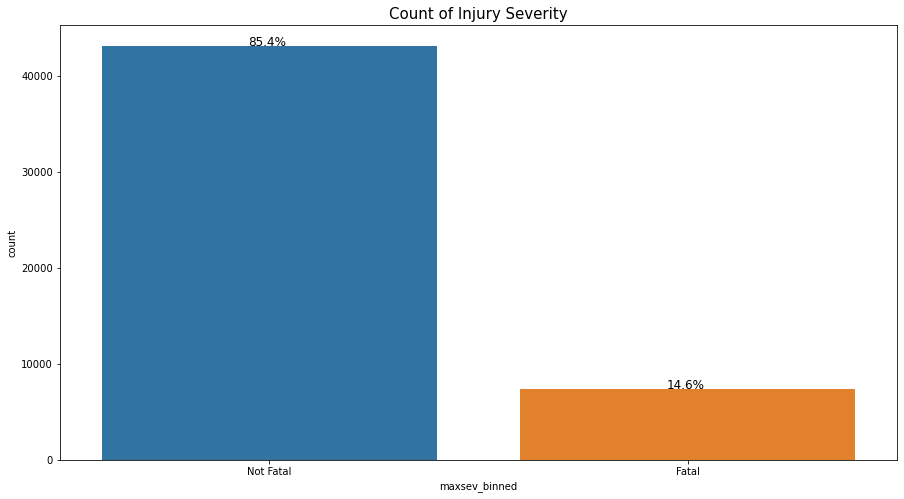

In [67]:
# Visualize class distribution. Note the imbalance that will be addressed later: not fatal 85% vs. fatal 15%
# https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

plt.figure(figsize = (15,8));
ax = sns.countplot('maxsev_binned', data=df)
without_hue(ax, df.maxsev_binned)
plt.title('Count of Injury Severity', fontsize=15);

#### **Response variable for task 2:** Age

Age ranges from 16-120, with mean age of 40, median of 35, and IQR of 27 years old. This aligns with what we know about legal driving age, working age, and retirement age.

          count       mean        std   min   25%   50%   75%    max
age_im  50535.0  39.552548  17.556665  16.0  25.0  35.0  52.0  120.0


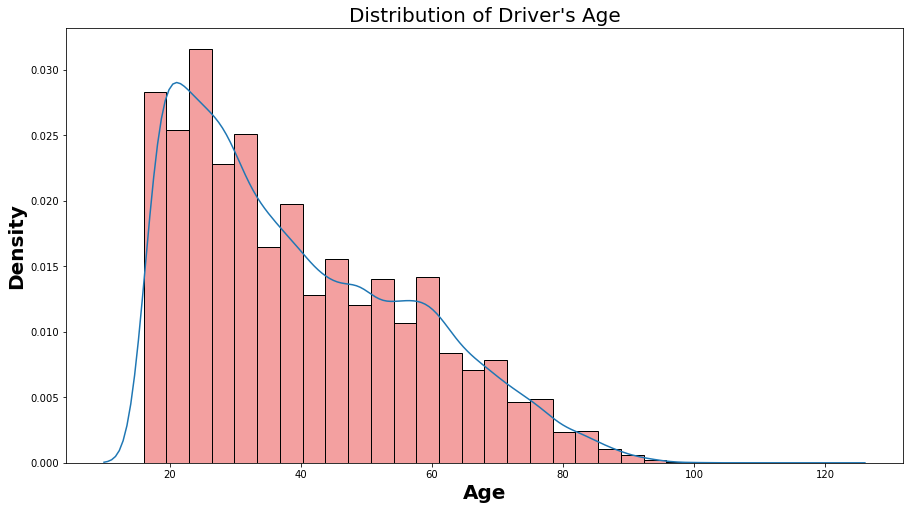

In [68]:
# Visualize age summary statistics
print(df[['age_im']].describe().T)

# Visualize age distribution
plt.figure(figsize = (15,8));
sns.histplot(df, x = "age_im", bins=30,  stat="density", color ='lightcoral');
sns.kdeplot(data=df, x = "age_im");
plt.xlabel('Age', weight = 1000, size=20)
plt.ylabel('Density', weight = 1000, size=20)
plt.title("Distribution of Driver's Age", size=20);

### End of data cleaning. Review final dataset

In [69]:
# Remove features that are not useful for modeling or redundant post binning
# Recall from summary those features are:
#  - `makename` (too many levels)
#  - `wrk_zonename` (99% of one class)
#  - `hour_imname` (unnecessary with `hour_binned`)
#  - `vspd_lim` (unnecessary with `speeding_status`) 
#  - `body_type_x` (unnecessary with `body_type_binned`)
#  - `weathername` (unecessary with `weather_binned`)
#  - `typ_intname` (unnecessary with `intersection_binned`)
#  - `maxsev_imname` (unnecessary with `maxsev_binned`)
#  - `trav_sp` (unnecessary with `trav_sp_imputed`) this will be removed later after imputation

df = df[df.columns.difference(['body_typname_x', 'typ_intname', 'weathername', 'rest_usename', 'hour_imname', 'vspd_lim'])]

In [70]:
# Check for duplicates
# Recall duplicated casenum was taken cared of during merge
# Here we check for duplicates of instances excluding `casenum`
df.duplicated().sum()

0

In [71]:
# Confirm there are zero NA values
df.isnull().sum().sum()

0

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50535 entries, 0 to 54471
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_im               50535 non-null  int64  
 1   alchl_imname         50535 non-null  object 
 2   body_type_binned     50535 non-null  int64  
 3   hour_binned          50535 non-null  object 
 4   int_hwyname          50535 non-null  object 
 5   intersection_binned  50535 non-null  object 
 6   lgtcon_imname        50535 non-null  object 
 7   maxsev_binned        50535 non-null  object 
 8   maxsev_imname        50535 non-null  object 
 9   mod_yearname_x       50535 non-null  int64  
 10  pcrash1_imname       50535 non-null  object 
 11  regionname           50535 non-null  object 
 12  reljct1_imname       50535 non-null  object 
 13  restraint_binned     50535 non-null  object 
 14  sex_imname           50535 non-null  object 
 15  speeding_status      50535 non-null 

In [73]:
display(df)

,age_im,alchl_imname,body_type_binned,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,maxsev_imname,mod_yearname_x,...,sex_imname,speeding_status,trav_sp,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
0,61,No Alcohol Involved,1,Morning,No,Yes,Daylight,Not Fatal,No Apparent Injury,2018,...,Female,unknown,25.0,Rural,Five lanes,Snow,Traffic control signal(on colors) not known wh...,"Two-Way, Not Divided",Not Clear,Wednesday
1,23,No Alcohol Involved,1,Night,No,No,Dark - Not Lighted,Not Fatal,Suspected Minor Injury,2013,...,Male,speeding,45.0,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Wednesday
3,20,No Alcohol Involved,2,Afternoon,Yes,No,Daylight,Not Fatal,No Apparent Injury,2015,...,Male,not speeding,65.0,Rural,Two lanes,Snow,No Controls,"Two-Way, Divided, Positive Median Barrier",Wintery,Wednesday
4,23,No Alcohol Involved,6,Evening,No,No,Dark - Not Lighted,Not Fatal,No Apparent Injury,2004,...,Male,unknown,998.0,Rural,NR/UNK,Snow,Warning Sign,NR/UNK,Wintery,Wednesday
5,57,No Alcohol Involved,3,Evening,No,No,Dark - Not Lighted,Not Fatal,Possible Injury,2003,...,Female,unknown,998.0,Rural,NR/UNK,Dry,No Controls,NR/UNK,Clear,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54467,61,No Alcohol Involved,2,Afternoon,No,No,Daylight,Not Fatal,No Apparent Injury,2017,...,Female,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Monday
54468,70,No Alcohol Involved,3,Evening,No,No,Daylight,Not Fatal,Suspected Minor Injury,2019,...,Male,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Not Clear,Wednesday
54469,59,No Alcohol Involved,6,Evening,No,No,Dark - Not Lighted,Not Fatal,Possible Injury,1999,...,Male,unknown,998.0,Urban,Two lanes,Dry,NR/UNK/OTH,"Two-Way, Not Divided",Clear,Thursday
54470,67,No Alcohol Involved,3,Morning,No,No,Daylight,Not Fatal,Suspected Minor Injury,2006,...,Male,unknown,998.0,Urban,Two lanes,Dry,NR/UNK/OTH,"Two-Way, Not Divided",Clear,Tuesday


## Begin data preprocessing

In [74]:
# Split data 80/20 train test with 10 fold stratified cross validation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["maxsev_binned"])

In [75]:
# code to scale features
scaler = StandardScaler()

# Fit the scaler on the training set age column, and transform (scale) the training set age column
train_df.loc[:, ["age_im"]] = scaler.fit_transform(X=train_df.loc[:, ["age_im"]])

# Using means and standard deviations from training set, scale the test set
test_df.loc[:, ["age_im"]] = scaler.transform(X=test_df.loc[:, ["age_im"]])

In [76]:
# code for one hot encode
features_to_ohe = ["hour_binned", "intersection_binned", "lgtcon_imname", "pcrash1_imname", "regionname", 
                   "restraint_binned", "vtrafconname", "vtrafwayname", "weather_binned", "wkdy_imname", 
                   "vnum_lanname", "vsurcondname", "speeding_status"]

# Features that need to become binary
binary_features = ["urbanicityname", "alchl_imname", "reljct1_imname", "int_hwyname", "sex_imname"]

# List of all the features that are not being converted to binary, or being OneHotEncoder
# (Just a list of all features not in either of the two lists above).
non_encoded_features = [col for col in df.columns if col not in features_to_ohe + binary_features]

# Map each soon to be binary feature to its two initial values
binary_encoding_map = {feature:df[feature].unique().tolist() for feature in binary_features}

# Instantiate the OrdinalEncoder that will create the binary columns
ord_encoder = OrdinalEncoder(categories=[value for value in binary_encoding_map.values()])

# Map each feature that will be OneHotEncoded to a list of all possible categories that feature can take on. 
oridnal_encoding_map = {feature:df[feature].unique().tolist() for feature in features_to_ohe}

# Instantiate the OneHotEncoder, telling it what the possible categories are for each feature.
oh_encoder = OneHotEncoder(categories=[value for value in oridnal_encoding_map.values()]) 

encoders = ColumnTransformer(transformers=[("ordinal_encoder", ord_encoder, binary_features), 
                                           ("one_hot_encoder", oh_encoder, features_to_ohe)], 
                             remainder="passthrough",
                             sparse_threshold=0,
                             n_jobs=-1)

# Create a dataframe of all the encoded columns in the training set
train_encoded_features = pd.DataFrame(encoders.fit_transform(train_df.drop(columns=non_encoded_features)), 
                                      columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the training set where all columns that need to be encoded are now encoded.
train_encoded_df = pd.concat(objs=[train_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   train_encoded_features.reset_index(drop=True)], 
                             axis='columns')

# Create a dataframe of all encoded (one hot and ordinal) columns for the test set
test_encoded_features = pd.DataFrame(encoders.transform(test_df.drop(columns=non_encoded_features)), 
                                     columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the test set where all columns that need to be encoded are now encoded.
test_encoded_df = pd.concat(objs=[test_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   test_encoded_features.reset_index(drop=True)], 
                             axis='columns')

#### Imputing travel speed

In [77]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Set the placeholder values (which need to be imputed) to NaN
train_encoded_df.loc[train_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan
test_encoded_df.loc[test_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan

# Set up version of training dataset to be used for imputing trav_sp
imputer_train_df = train_encoded_df.copy(deep=True)
imputer_train_df.drop(columns=["maxsev_binned"], inplace=True)
severity_ord_enc = OrdinalEncoder(categories=[["No Apparent Injury", "Possible Injury", "Suspected Minor Injury", "Suspected Serious Injury", "Fatal Injury"]])
imputer_train_df["maxsev_imname"] = severity_ord_enc.fit_transform(X=imputer_train_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Setting the minimum and maximum value the imputer can impute for a traveling speed. 
min_trav_sp = 15
max_trav_sp = 151
impute_min_values = [-np.inf if col != "trav_sp" else min_trav_sp for col in imputer_train_df.columns]
impute_max_values = [np.inf if col != "trav_sp" else max_trav_sp for col in imputer_train_df.columns]

# Instantiate the iterative imputer
imputer = IterativeImputer(min_value=impute_min_values, 
                           max_value=impute_max_values,
                           random_state=42)

# Fit the iterative imputer on the training set, and impute the training set
imputer_train_result = imputer.fit_transform(X=imputer_train_df)

# Take the output of running iteratrive imputer on the train set, and convert it to a dataframe
# Save the imputed version of traveling speed to train_encoded_df
imputer_train_result_df = pd.DataFrame(imputer_train_result, 
                                       columns=imputer.get_feature_names_out())
train_encoded_df["trav_sp_imputed"] = imputer_train_result_df["trav_sp"]

# Set up the version of the test dataset that will run through the imputer
imputer_test_df = test_encoded_df.copy(deep=True)
imputer_test_df.drop(columns=["maxsev_binned"], inplace=True)
imputer_test_df["maxsev_imname"] = severity_ord_enc.transform(X=imputer_test_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Run the test data through the imputer
imputer_test_result = imputer.transform(X=imputer_test_df)

# Convert the output of running the test data through iterative imputer to a dataframe
imputer_test_result_df = pd.DataFrame(imputer_test_result, 
                                      columns=imputer.get_feature_names_out())
test_encoded_df["trav_sp_imputed"] = imputer_test_result_df["trav_sp"]

In [78]:
# Remove maxsev_imname from all dataframes
df.drop(columns="maxsev_imname", inplace=True)

# Dropping the Non-Imputed versions of travel speed, now that imputation has been performed
train_imputed_df = train_encoded_df.drop(columns=["trav_sp", "maxsev_imname"])
test_imputed_df = test_encoded_df.drop(columns=["trav_sp", "maxsev_imname"])

#### Scaling travel speed

In [79]:
speed_scaler = StandardScaler()

# Fit and transform the scaler on the training set
train_imputed_df["trav_sp_scaled"] = speed_scaler.fit_transform(train_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Only transform on the test set (no data leakage)
test_imputed_df["trav_sp_scaled"] = speed_scaler.transform(test_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Use these dataframes moving forward
# The final, fully preprocessed dataframes (all features encoded and imputed as needed)
# Using "pp" to stand for preprocessed
train_pp_df = train_imputed_df.drop(columns="trav_sp_imputed")
test_pp_df = test_imputed_df.drop(columns="trav_sp_imputed")

In [80]:
train_pp_df.head()

,age_im,body_type_binned,maxsev_binned,mod_yearname_x,ordinal_encoder__urbanicityname,ordinal_encoder__alchl_imname,ordinal_encoder__reljct1_imname,ordinal_encoder__int_hwyname,ordinal_encoder__sex_imname,one_hot_encoder__hour_binned_Morning,...,one_hot_encoder__vsurcondname_Ice/Frost,one_hot_encoder__vsurcondname_Water (Standing or Moving),one_hot_encoder__vsurcondname_Slush,one_hot_encoder__vsurcondname_Sand,"one_hot_encoder__vsurcondname_Mud, Dirt or Gravel",one_hot_encoder__vsurcondname_Oil,one_hot_encoder__speeding_status_unknown,one_hot_encoder__speeding_status_speeding,one_hot_encoder__speeding_status_not speeding,trav_sp_scaled
0,2.530925,1,Not Fatal,2015,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.576739
1,0.194944,3,Not Fatal,1997,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.029827
2,1.961173,4,Not Fatal,2016,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.926793
3,0.365870,1,Not Fatal,2018,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.779565
4,-0.602708,1,Not Fatal,2008,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.276033


### Visualize Variable Representation

In [81]:
pd.set_option('display.max_rows', None)
table = [
    ['age_im', 'int'],
    ['body_type_binned', 'int should be an obj though?'],
    ['maxsev_binned', 'object'],
    ['maxsev_imname', 'object'],
    ['mod_yearname_x', 'int'],
    ['ordinal_encoder__urbanicityname', 'ordinal encoded'],
    ['ordinal_encoder__alchl_imname', 'ordinal encoded'],
    ['ordinal_encoder__reljct1_imname', 'ordinal encoded'],
    ['ordinal_encoder__int_hwyname', 'ordinal encoded'],
    ['ordinal_encoder__sex_imname', 'ordinal encoded'],
    ['one_hot_encoder__hour_binned_Morning', 'one hot encoded'],
    ['one_hot_encoder__hour_binned_Night', 'one hot encoded'],
    ['one_hot_encoder__hour_binned_Afternoon', 'one hot encoded'],
    ['one_hot_encoder__hour_binned_Evening', 'one hot encoded'],
    ['one_hot_encoder__intersection_binned_Yes', 'one hot encoded'],
    ['one_hot_encoder__intersection_binned_No', 'one hot encoded'],
    ['one_hot_encoder__intersection_binned_Other','one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Daylight', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dark - Not Lighted', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dawn', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dark - Lighted', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dark - Unknown Lighting', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Dusk', 'one hot encoded'],
    ['one_hot_encoder__lgtcon_imname_Other', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Going Straight', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Negotiating a Curve', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Stopped in Roadway', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Turning Right', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Turning Left', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Starting in Road', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Changing Lanes', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Decelerating in Road', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Passing or Overtaking Another Vehicle', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Backing Up (other than for Parking Position)', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Making a U-turn', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Accelerating in Road', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Disabled or "Parked" in Travel lane', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Leaving a Parking Position', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Merging', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Entering a Parking Position', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Other(specify:)', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_Successful Avoidance Maneuver to a Previous Critical Event', 'one hot encoded'],
    ['one_hot_encoder__pcrash1_imname_No Driver Present / Unknown if Driver Present', 'one hot encoded'],
    ['one_hot_encoder__regionname_West' 'one_hot_encoder__regionname_South', 'one hot encoded'],
    ['one_hot_encoder__regionname_Northeast', 'one hot encoded'],
    ['one_hot_encoder__regionname_Midwest', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_Full', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_Other', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_None', 'one hot encoded'],
    ['one_hot_encoder__restraint_binned_Minimal', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Traffic control signal(on colors) not known whether or not Pedestrian Signal', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_No Controls', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Warning Sign', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_NR/UNK/OTH', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Stop Sign', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Traffic control signal (on colors) without Pedestrian Signal', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Traffic control signal (on colors) with Pedestrian Signal', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Railway Crossing Device', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Yield Sign', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Flashing Traffic Control Signal', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Person', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_School Zone Sign/Device', 'one hot encoded'],
    ['one_hot_encoder__vtrafconname_Lane Use Control Signal', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way, Not Divided', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way,  Divided, Positive  Median Barrier', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_NR/UNK', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Entrance/Exit Ramp', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way, Divided, Unprotected Median', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_One-Way Trafficway', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Two-Way, Not Divided With a Continuous Left-Turn Lane', 'one hot encoded'],
    ['one_hot_encoder__vtrafwayname_Non-Trafficway or Driveway Access', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Not Clear', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Clear', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Wintery', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Other', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Rain', 'one hot encoded'],
    ['one_hot_encoder__weather_binned_Windy', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Wednesday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Friday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Thursday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Saturday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Sunday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Monday', 'one hot encoded'],
    ['one_hot_encoder__wkdy_imname_Tuesday', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Five lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Two lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_NR/UNK', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Three lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Four lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Six lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Non-Trafficway or Driveway Access', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_Seven or more lanes', 'one hot encoded'],
    ['one_hot_encoder__vnum_lanname_One lane', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Snow', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Dry', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_NR/UNK/OTH', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Wet', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Non-Trafficway or Driveway Access', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Ice/Frost', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Water (Standing or Moving)', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Slush', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Sand', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Mud, Dirt or Gravel', 'one hot encoded'],
    ['one_hot_encoder__vsurcondname_Oil', 'one hot encoded'],
    ['one_hot_encoder__speeding_status_unknown', 'one hot encoded'],
    ['one_hot_encoder__speeding_status_speeding', 'one hot encoded'],
    ['one_hot_encoder__speeding_status_not speeding', 'one hot encoded'],
    ['trav_sp_scaled', 'float']
]
table = pd.DataFrame(table, columns=['Variable', 'Representation'])
table

,Variable,Representation
0,age_im,int
1,body_type_binned,int should be an obj though?
2,maxsev_binned,object
3,maxsev_imname,object
4,mod_yearname_x,int
5,ordinal_encoder__urbanicityname,ordinal encoded
6,ordinal_encoder__alchl_imname,ordinal encoded
7,ordinal_encoder__reljct1_imname,ordinal encoded
8,ordinal_encoder__int_hwyname,ordinal encoded
9,ordinal_encoder__sex_imname,ordinal encoded


In [82]:
pd.reset_option("display.max_rows")

### Feature Selection

This was conducted through three different feature importance methods: Random Forest, SelectKBest, and Mutual Information.

The three plots below depict the important features in descending order. We've highlighted the top 6 from each method.

**Random Forest:**
1. Car's traveling speed
2. Driver's age
3. Year of vehicle
4. Vehicle's body type
5. Restraint use
6. Driver's alcohol status

**SelectKBest:**
1. Restraint use
2. Car's traveling speed
3. Driver's alcohol status
4. Hour of accident
5. Lighting condition at the time of accident
6. Driver's speeding status

**Mutual Information:**
1. Restraint use
2. Driver's alcohol status
3. Vehicle's body type
4. Hour of accident
5. Lighting condition at the time of accident
6. Driver's speeding status

In summary, the overlapping features were restraint use, body type, alcohol use, hour of accident, travel speed, whether driver was speeding, and lighting condition. This aligned with our intuition that injury severity is most likely affected by speed, alcohol, restraint use, and lighting (natural or artificial). Body type is an intriguing feature that we did not expect to see here. We will note that most of the features in the top 20 were from careful binning and newly added/derived features. Lastly, it is interesting to see random forest chose all continuous variables first.

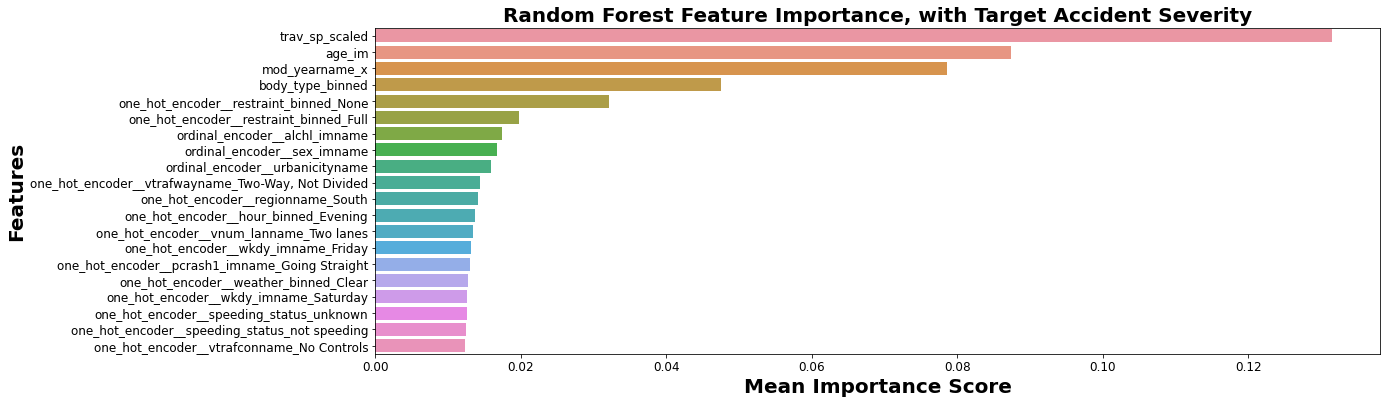

In [84]:
# code for feature selection: random forest feature importance

# We will plot importances for the top NUM_IMPORTANCES_TO_PLOT features (by mean score)
# This will be used for rf, selectkbest and mutualinfo
NUM_IMPORTANCES_TO_PLOT = 20

# Split the train set into X and y
X = train_pp_df.drop(columns=["maxsev_binned"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Instantiate and fit the random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Calculates the standard deviation of the importance score for each feature.
# For each of the 100 trees in the random forest, get the importance scores for all 106 features.
# Then take the standard deviation of those 100 scores for each of the 106 features.
# Result is 106 standard deviations, where each standard deviation was calculated from 100 values. 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
rf_importance_stds = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create a dataframe of importance scores
rf_importances_df = pd.DataFrame({"feature_name":rf.feature_names_in_, 
                                  "mean_importance_score":rf.feature_importances_, 
                                  "std_importance_score":rf_importance_stds})

# Sort the dataframe, largest to smallest mean score
rf_importances_df.sort_values(by="mean_importance_score", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
rf_importances_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
rf_plot_df = rf_importances_df.loc[rf_importances_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="mean_importance_score", data=rf_plot_df, ax=ax, orient="h")

ax.set_title("Random Forest Feature Importance, with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Mean Importance Score", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

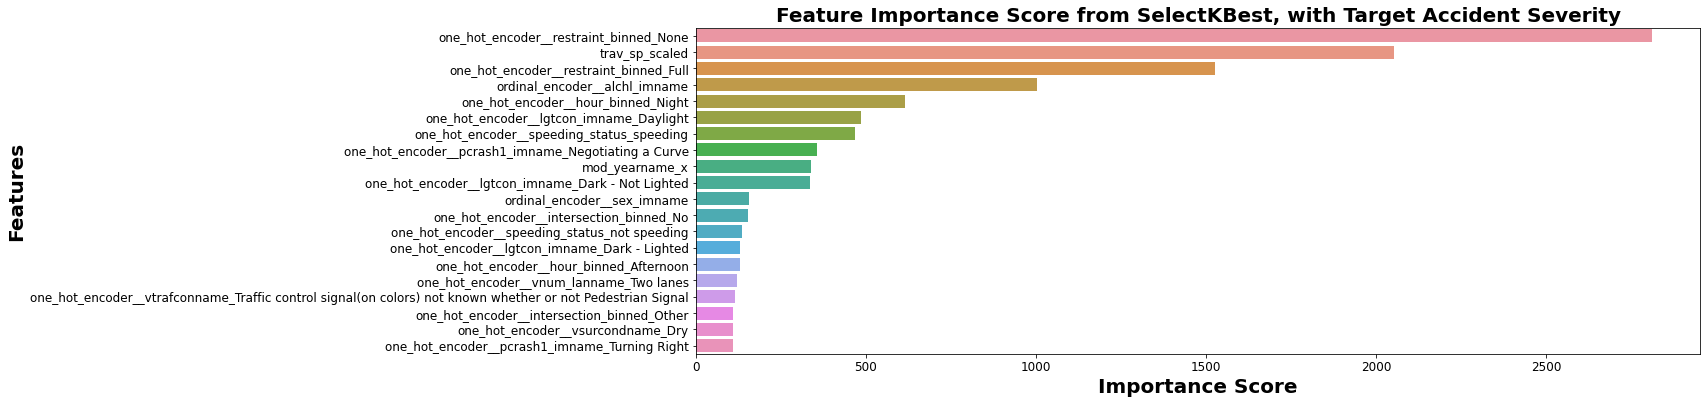

In [85]:
# code for feature selection: selectkbest

# Split the train set into X and y
X = train_pp_df.drop(columns=["maxsev_binned"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Instantiate and fit the random forest classifier
kselector = SelectKBest(k=NUM_IMPORTANCES_TO_PLOT)
kselector.fit(X, y)

# Create a dataframe of scores
kbest_scores_df = pd.DataFrame({"feature_name":kselector.feature_names_in_, 
                                  "score":kselector.scores_, 
                                  "p_value":kselector.pvalues_})


# Sort the dataframe, largest to smallest mean score
kbest_scores_df.sort_values(by="score", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
kbest_scores_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
kbest_plot_df = kbest_scores_df.loc[kbest_scores_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="score", data=kbest_plot_df, ax=ax, orient="h")

ax.set_title("Feature Importance Score from SelectKBest, with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Importance Score", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

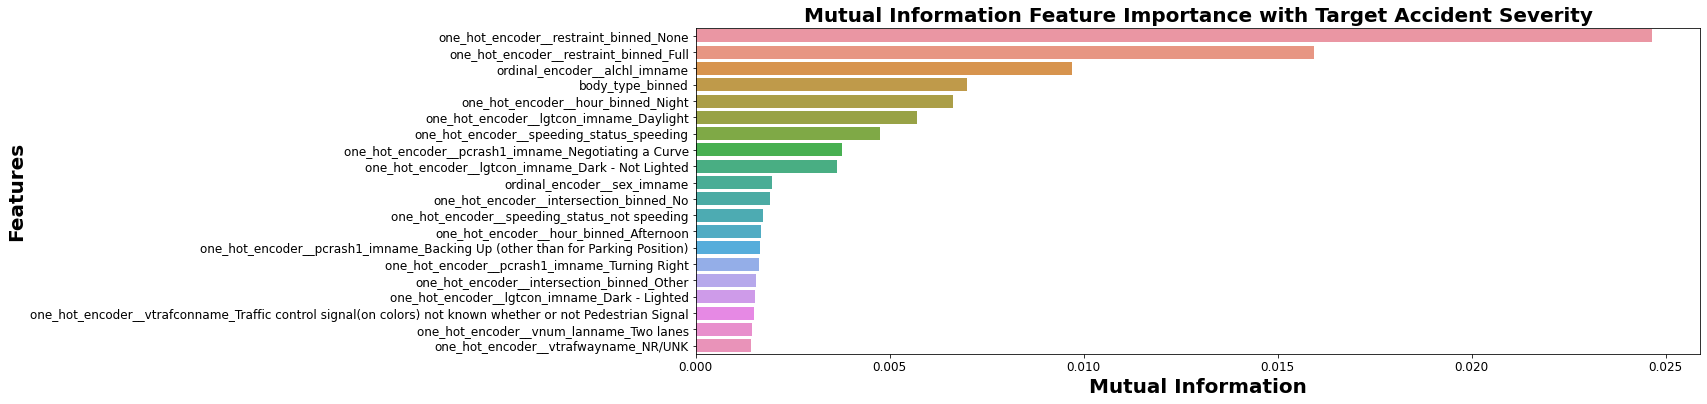

In [87]:
# code for feature selection: mutual information

# NOTE: mutual info is only considering discrete features

# Split the train set into X and y
X = train_pp_df.drop(columns=["maxsev_binned", "age_im", "mod_yearname_x", "trav_sp_scaled"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Instantiate and fit the mutual information module
mutual_info = mutual_info_classif(X=X, y=y, discrete_features=True, n_neighbors=3, random_state=42)

# Create a dataframe of scores
mutual_info_df = pd.DataFrame({"mutual_information":mutual_info, 
                               "feature_name":X.columns.tolist()})

# Sort the dataframe, largest to smallest score
mutual_info_df.sort_values(by="mutual_information", ascending=False, inplace=True)

# reset the index so it starts back at 1, don't keep the old index as a column
mutual_info_df.reset_index(drop=True, inplace=True)

# Create a truncated version of the dataframe containing only the first NUM_IMPORTANCES_TO_PLOT rows
mutual_info_plot_df = mutual_info_df.loc[mutual_info_df.index < NUM_IMPORTANCES_TO_PLOT, :]

# Create a horizontal bar plot of importance scores
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(y="feature_name", x="mutual_information", data=mutual_info_plot_df, ax=ax, orient="h")

ax.set_title("Mutual Information Feature Importance with Target Accident Severity", fontsize=20, weight=1000)
ax.set_xlabel("Mutual Information", size=20, weight=1_000)
ax.set_ylabel("Features", size=20, weight=1_000)
ax.tick_params(axis='both', labelsize=12)

# Data Preparation Part 2
Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
(5)

In [88]:
pd.set_option('max_colwidth', None)
data = [
    ['restraint_binned', 'Object/Categorical', 'Restraint equipment used by driver', 'Full, Minimal, None, Other (one hot encoded)'],
    ['pcrash1_imname', 'Object/Categorical', "Driver's pre-event movenent prior to recognition of critical event", '19 (one hot encoded)'],
    ['speeding_status', 'Object/Categorical', 'Whether driver was above or below speeding limit', 'Speeding, Not Speeding, Unknown (one hot encoded)'],
    ['hour_binned', 'Object/Categorical', 'Time of accident', 'Morning (6am-noon), afternoon (noon-6pm), evening (6pm-midnight), night (midnight-6am) (one hot encoded)'],
    ['body_type_binned', 'Object/Categorical', 'Body type of vehicle', '12 (one hot encoded)'],
    ['weather_binned', 'Object/Categorical', 'Weather at time of accident', 'Clear, Not Clear, Rain, Wintery, Windy, Other (one hot encoded)'],
    ['trav_sp_imputed', 'Int/Numerical', 'Traveling speed of the car', '-'],
    ['intersection_binned', 'Object/Categorical', 'Whether accident took place at an intersection', 'Yes,  No, Other (one hot encoded'],
    ['maxsev_binned', 'Object/Categorical', 'Severity of injury sustained by the driver', 'Fatal, Not Fatal']
]
data = pd.DataFrame(data, columns=[['Feature Name', 'Datatype', 'Description', 'Levels, if applicable']])
print('The original dataset (after initial merging and filtering) was 54,473 observations and 24 columns.\nAfter caring for NA values, more filtering/binning as needed, and hot encoding, the final dataset is 50,535 observations and 24 columns.\nBelow is a description of the newly formed or binned variables.')
data

The original dataset (after initial merging and filtering) was 54,473 observations and 24 columns.
After caring for NA values, more filtering/binning as needed, and hot encoding, the final dataset is 50,535 observations and 24 columns.
Below is a description of the newly formed or binned variables.


,Feature Name,Datatype,Description,"Levels, if applicable"
0,restraint_binned,Object/Categorical,Restraint equipment used by driver,"Full, Minimal, None, Other (one hot encoded)"
1,pcrash1_imname,Object/Categorical,Driver's pre-event movenent prior to recognition of critical event,19 (one hot encoded)
2,speeding_status,Object/Categorical,Whether driver was above or below speeding limit,"Speeding, Not Speeding, Unknown (one hot encoded)"
3,hour_binned,Object/Categorical,Time of accident,"Morning (6am-noon), afternoon (noon-6pm), evening (6pm-midnight), night (midnight-6am) (one hot encoded)"
4,body_type_binned,Object/Categorical,Body type of vehicle,12 (one hot encoded)
5,weather_binned,Object/Categorical,Weather at time of accident,"Clear, Not Clear, Rain, Wintery, Windy, Other (one hot encoded)"
6,trav_sp_imputed,Int/Numerical,Traveling speed of the car,-
7,intersection_binned,Object/Categorical,Whether accident took place at an intersection,"Yes, No, Other (one hot encoded"
8,maxsev_binned,Object/Categorical,Severity of injury sustained by the driver,"Fatal, Not Fatal"


In [89]:
pd.reset_option("display.max_columns")

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50535 entries, 0 to 54471
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_im               50535 non-null  int64  
 1   alchl_imname         50535 non-null  object 
 2   body_type_binned     50535 non-null  int64  
 3   hour_binned          50535 non-null  object 
 4   int_hwyname          50535 non-null  object 
 5   intersection_binned  50535 non-null  object 
 6   lgtcon_imname        50535 non-null  object 
 7   maxsev_binned        50535 non-null  object 
 8   mod_yearname_x       50535 non-null  int64  
 9   pcrash1_imname       50535 non-null  object 
 10  regionname           50535 non-null  object 
 11  reljct1_imname       50535 non-null  object 
 12  restraint_binned     50535 non-null  object 
 13  sex_imname           50535 non-null  object 
 14  speeding_status      50535 non-null  object 
 15  trav_sp              50535 non-null 

In [91]:
display(df)

,age_im,alchl_imname,body_type_binned,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,mod_yearname_x,pcrash1_imname,...,sex_imname,speeding_status,trav_sp,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
0,61,No Alcohol Involved,1,Morning,No,Yes,Daylight,Not Fatal,2018,Going Straight,...,Female,unknown,25.0,Rural,Five lanes,Snow,Traffic control signal(on colors) not known whether or not Pedestrian Signal,"Two-Way, Not Divided",Not Clear,Wednesday
1,23,No Alcohol Involved,1,Night,No,No,Dark - Not Lighted,Not Fatal,2013,Going Straight,...,Male,speeding,45.0,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Wednesday
3,20,No Alcohol Involved,2,Afternoon,Yes,No,Daylight,Not Fatal,2015,Going Straight,...,Male,not speeding,65.0,Rural,Two lanes,Snow,No Controls,"Two-Way, Divided, Positive Median Barrier",Wintery,Wednesday
4,23,No Alcohol Involved,6,Evening,No,No,Dark - Not Lighted,Not Fatal,2004,Negotiating a Curve,...,Male,unknown,998.0,Rural,NR/UNK,Snow,Warning Sign,NR/UNK,Wintery,Wednesday
5,57,No Alcohol Involved,3,Evening,No,No,Dark - Not Lighted,Not Fatal,2003,Going Straight,...,Female,unknown,998.0,Rural,NR/UNK,Dry,No Controls,NR/UNK,Clear,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54467,61,No Alcohol Involved,2,Afternoon,No,No,Daylight,Not Fatal,2017,Going Straight,...,Female,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Monday
54468,70,No Alcohol Involved,3,Evening,No,No,Daylight,Not Fatal,2019,Going Straight,...,Male,unknown,998.0,Rural,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Not Clear,Wednesday
54469,59,No Alcohol Involved,6,Evening,No,No,Dark - Not Lighted,Not Fatal,1999,Negotiating a Curve,...,Male,unknown,998.0,Urban,Two lanes,Dry,NR/UNK/OTH,"Two-Way, Not Divided",Clear,Thursday
54470,67,No Alcohol Involved,3,Morning,No,No,Daylight,Not Fatal,2006,Going Straight,...,Male,unknown,998.0,Urban,Two lanes,Dry,NR/UNK/OTH,"Two-Way, Not Divided",Clear,Tuesday


# Model and Evaluation 1
- Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). 
- Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
(10)

## Accident Severity Clasification
The evaluation metric used to classify driver's injury severity is F1. This is an appropriate metric because the response, injury severity, is a categorical variable. Due to the class imbalance, metrics such as accuracy is not desirable because the model could have a high no-information-rate i.e., choose the most populous category and be correct most of the time. F1 is a harmonic mean between precision and recall and is much more conducive to discerning the model's performance.

## Age Regression
The evaluation metric to classify driver's age is MSE. This is an appropriate metric because the response, age, is a continuous variable. Add more later.

# Model and Evaluation 2
- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). 
- Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
(10)

## Injury Severity Clasification
We used stratified 10 fold cross validation due to the class imbalance of injury severity (85% not fatal, 15% fatal). k-fold assumes a uniform probablity distribution, however in an imbalanced class, it is highly likely that most folds heavily lack representation of fatal. In which case, the model will predict the majority class thus resulting in a misleading confusion matrix. Stratified k-fold cross validation mitigates this problem by matching the training data distribution and imposing equal class representation in each fold.

## Age Regression
Words

In [ ]:
# The code to split the data was ran in the previous section but for completeness, it is pasted below
# Split data 80/20 train test with 10 fold stratified cross validation
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["maxsev_binned"])

# Model and Evaluation 3
- Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). 
- Two modeling techniques must be new (but the third could be SVM or logistic regression). 
- Adjust parameters as appropriate to increase generalization performance using your chosen metric. 
- You must investigate different parameters of the algorithms!
(20)

## Accident Severity Classification

### LightGBM for Classification

In [92]:
%%time

# Split the train set into X and y
# The extra .rename() is only because LightGBM didn't like some of the characters in the column names. (brackets)
# https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same
X = train_pp_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)).drop(columns=["maxsev_binned"])
y = train_pp_df.loc[:, "maxsev_binned"]

param_distributions = {'num_leaves':[21, 26, 31, 36, 41], 
                       'max_depth':[-1, 10], 
                       'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3]}

rs_severity_lgbm_clf = RandomizedSearchCV(estimator=LGBMClassifier(boosting_type="gbdt", random_state=42), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'f1':make_scorer(f1_score, pos_label="Fatal"), 'accuracy': make_scorer(accuracy_score)}, 
                                      refit='f1',
                                      n_jobs=-1, 
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

rs_severity_lgbm_clf.fit(X, y)

lgbm_rs_severity_df = pd.DataFrame(rs_severity_lgbm_clf.cv_results_)

# Sort the randomsearch results dataframe from highest to lowest test f1
lgbm_rs_severity_df.sort_values(by="mean_test_f1", ascending=False, inplace=True)

# Reorder columns so its easier to see metrics
first_columns = ["mean_test_f1", "mean_train_f1", "mean_test_accuracy", "mean_train_accuracy"]
new_column_order = first_columns + [column for column in lgbm_rs_severity_df.columns if column not in first_columns]
lgbm_rs_severity_df = lgbm_rs_severity_df.loc[:, new_column_order]

# View the randomsearch results
lgbm_rs_severity_df.head()

CPU times: total: 3.7 s
Wall time: 24.2 s


,mean_test_f1,mean_train_f1,mean_test_accuracy,mean_train_accuracy,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_max_depth,...,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,std_train_accuracy
5,0.446185,0.726088,0.879687,0.934781,1.225561,0.195848,0.096901,0.009851,41,-1,...,0.934616,0.935056,0.935523,0.934671,0.934286,0.933791,0.935303,0.935030,0.934618,0.000476
9,0.440726,0.652619,0.879613,0.920685,1.029519,0.186379,0.076355,0.017207,31,10,...,0.920901,0.921121,0.921946,0.920187,0.919390,0.920407,0.920682,0.920519,0.922140,0.000852
7,0.420565,0.597304,0.878648,0.911700,1.276539,0.113622,0.102998,0.018423,36,10,...,0.910952,0.912354,0.912381,0.911062,0.911117,0.913179,0.911365,0.911394,0.911697,0.000680
6,0.401146,0.545963,0.877436,0.903587,1.234790,0.115926,0.101488,0.015555,36,-1,...,0.903504,0.903642,0.903807,0.903532,0.902405,0.904054,0.903312,0.904304,0.903534,0.000480
3,0.401084,0.502455,0.878178,0.896255,1.321799,0.070713,0.088702,0.015709,21,10,...,0.895836,0.897815,0.894242,0.895287,0.895561,0.898035,0.897348,0.895509,0.896499,0.001144


### Random Forest for Classification

In [93]:
%%time

X = train_pp_df.drop(columns=["maxsev_binned"])
y = train_pp_df.loc[:, "maxsev_binned"]

param_distributions = {'n_estimators':[num_trees for num_trees in range(100, 300)], 
                       'max_depth':[None, 10, 11, 12, 13, 14, 15], 
                       'min_samples_split':[2, 5, 10], 
                       'min_samples_leaf':[1, 2, 3]}

rs_severity_rf_clf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'f1':make_scorer(f1_score, pos_label="Fatal"), 'accuracy': make_scorer(accuracy_score)}, 
                                      refit='f1',
                                      n_jobs=-1, 
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

rs_severity_rf_clf.fit(X, y)

rf_rs_severity_df = pd.DataFrame(rs_severity_rf_clf.cv_results_)

# Sort the randomsearch results dataframe from highest to lowest test f1
rf_rs_severity_df.sort_values(by="mean_test_f1", ascending=False, inplace=True)

# Reorder columns so its easier to see metrics
first_columns = ["mean_test_f1", "mean_train_f1", "mean_test_accuracy", "mean_train_accuracy"]
new_column_order = first_columns + [column for column in rf_rs_severity_df.columns if column not in first_columns]
rf_rs_severity_df = rf_rs_severity_df.loc[:, new_column_order]

# View the randomsearch results
rf_rs_severity_df.head()

CPU times: total: 9.78 s
Wall time: 6min 11s


,mean_test_f1,mean_train_f1,mean_test_accuracy,mean_train_accuracy,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,...,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,std_train_accuracy
8,0.228291,0.566448,0.865242,0.911096,41.099110,0.848146,0.835048,0.086630,166,10,...,0.910925,0.911997,0.912024,0.910183,0.910513,0.910980,0.911420,0.910405,0.911202,0.000594
1,0.227416,0.592976,0.865514,0.915177,41.117678,1.098066,0.772082,0.100896,160,5,...,0.915515,0.916202,0.915240,0.914031,0.914635,0.915817,0.915185,0.914473,0.915709,0.000633
5,0.204937,0.360246,0.864203,0.884703,38.796457,1.465510,0.856513,0.130322,184,10,...,0.884348,0.885640,0.885117,0.884375,0.884485,0.884430,0.884513,0.884571,0.885258,0.000440
4,0.199084,0.331831,0.864005,0.881466,51.699366,1.472223,1.088316,0.147139,264,10,...,0.880857,0.882149,0.881435,0.880775,0.880803,0.881187,0.881874,0.881493,0.882675,0.000589
0,0.189288,0.365303,0.863189,0.885745,33.140573,1.117392,0.630947,0.112898,170,2,...,0.885915,0.886327,0.886217,0.884623,0.884733,0.885997,0.886299,0.885368,0.886302,0.000609


### kNN for Classification

In [94]:
%%time

X = train_pp_df.drop(columns=["maxsev_binned"])
y = train_pp_df.loc[:, "maxsev_binned"]

# Search Odd values of K between 3 and 101
param_distributions = {'n_neighbors':[num_neighbors for num_neighbors in range(3, 102) if num_neighbors % 2 != 0]}

rs_severity_knn_clf = RandomizedSearchCV(estimator=KNeighborsClassifier(), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'f1':make_scorer(f1_score, pos_label="Fatal"), 'accuracy': make_scorer(accuracy_score)}, 
                                      refit='f1',
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

rs_severity_knn_clf.fit(X, y)

knn_rs_severity_df = pd.DataFrame(rs_severity_knn_clf.cv_results_)

# Sort the randomsearch results dataframe from highest to lowest test f1
knn_rs_severity_df.sort_values(by="mean_test_f1", ascending=False, inplace=True)

# Reorder columns so its easier to see metrics
first_columns = ["mean_test_f1", "mean_train_f1", "mean_test_accuracy", "mean_train_accuracy"]
new_column_order = first_columns + [column for column in knn_rs_severity_df.columns if column not in first_columns]
knn_rs_severity_df = knn_rs_severity_df.loc[:, new_column_order]

# View the randomsearch results
knn_rs_severity_df.head()

CPU times: total: 1h 4min 49s
Wall time: 7min 39s


,mean_test_f1,mean_train_f1,mean_test_accuracy,mean_train_accuracy,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,...,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,std_train_accuracy
0,0.049747,0.067356,0.855595,0.857236,0.064213,0.002086,0.557812,0.052079,29,{'n_neighbors': 29},...,0.857221,0.857359,0.857524,0.856837,0.857111,0.856974,0.857634,0.857170,0.857665,0.000287
4,0.040694,0.051467,0.855669,0.856571,0.064005,0.001261,0.554636,0.031777,37,{'n_neighbors': 37},...,0.856397,0.856754,0.856782,0.856342,0.856095,0.856287,0.856727,0.856676,0.857088,0.000278
9,0.040104,0.046994,0.855793,0.856348,0.064218,0.006312,0.602197,0.043372,41,{'n_neighbors': 41},...,0.856232,0.856672,0.856562,0.855957,0.855820,0.856095,0.856562,0.856126,0.856923,0.000335
7,0.029824,0.034342,0.855397,0.855818,0.060326,0.000639,0.610572,0.027115,53,{'n_neighbors': 53},...,0.855765,0.856150,0.856012,0.855270,0.855627,0.855682,0.856012,0.855494,0.856346,0.000304
6,0.029811,0.032651,0.855471,0.855746,0.063510,0.004852,0.637712,0.046934,55,{'n_neighbors': 55},...,0.855545,0.855985,0.855902,0.855243,0.855435,0.855655,0.855792,0.855714,0.856428,0.000308


## Age Regression

### Random Forest for Regression

In [95]:
X = train_pp_df.drop(columns=["age_im"])
y = train_pp_df.loc[:, "age_im"]

param_distributions = {'n_estimators':[num_trees for num_trees in range(100, 300)], 
                       'max_depth':[None, 10, 11, 12, 13, 14, 15], 
                       'min_samples_split':[2, 5, 10], 
                       'min_samples_leaf':[1, 2, 3]}

rs_severity_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'RMSE':make_scorer(f1_score, pos_label="Fatal"), 'accuracy': make_scorer(accuracy_score)}, 
                                      refit='f1',
                                      n_jobs=-1, 
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

In [96]:
X = train_pp_df.drop(columns=["age"])
y = train_pp_df.loc[:, "maxsev_binned"]

param_distributions = {'n_estimators':[num_trees for num_trees in range(100, 300)], 
                       'max_depth':[None, 10, 11, 12, 13, 14, 15], 
                       'min_samples_split':[2, 5, 10], 
                       'min_samples_leaf':[1, 2, 3]}

rs_severity_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), 
                                      param_distributions=param_distributions, 
                                      n_iter=10, 
                                      scoring={'f1':make_scorer(f1_score, pos_label="Fatal"), 'accuracy': make_scorer(accuracy_score)}, 
                                      refit='f1',
                                      n_jobs=-1, 
                                      cv=10, 
                                      random_state=42, 
                                      return_train_score=True, 
                                      error_score="raise")

rs_severity_rf.fit(X, y)

rf_rs_severity_df = pd.DataFrame(rs_severity_rf.cv_results_)

# Sort the randomsearch results dataframe from highest to lowest test f1
rf_rs_severity_df.sort_values(by="mean_test_f1", ascending=False, inplace=True)

# Reorder columns so its easier to see metrics
first_columns = ["mean_test_f1", "mean_train_f1", "mean_test_accuracy", "mean_train_accuracy"]
new_column_order = first_columns + [column for column in rf_rs_severity_df.columns if column not in first_columns]
rf_rs_severity_df = rf_rs_severity_df.loc[:, new_column_order]

# View the randomsearch results
rf_rs_severity_df.head()

KeyError: "['age'] not found in axis"

### kNN for Regression

### SVM for Regression

# Model and Evaluation 4
- Analyze the results using your chosen method of evaluation. 
- Use visualizations of the results to bolster the analysis. 
- Explain any visuals and analyze why they are interesting to someone that might use this model.
(10)

We need one plot of the winning model from each task.

## Accident Severity Classification

#### LightGBM Accident Severity Classifier

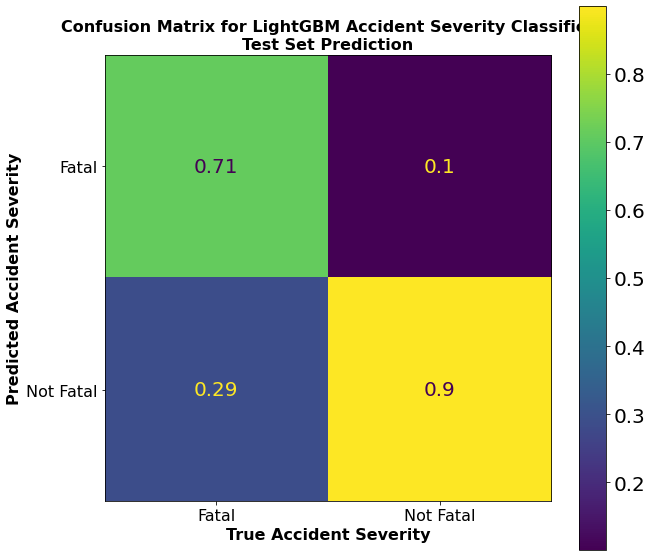

In [98]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Increase the font size for the values displayed inside the confusion matrix
plt.rc('font', **{'size':20})

# Setup the axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), squeeze=True)

# Plot the confusion matrix on the axis, using the estimator and test set
ConfusionMatrixDisplay.from_estimator(estimator=rs_severity_lgbm_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      normalize='pred', 
                                      ax=ax)

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("True Accident Severity", size=16, weight=1_000)
ax.set_ylabel("Predicted Accident Severity", size=16, weight=1_000)
ax.set_title("Confusion Matrix for LightGBM Accident Severity Classifier\nTest Set Prediction", size=16, weight=1_000);

#### Random Forest Accident Severity Classifier

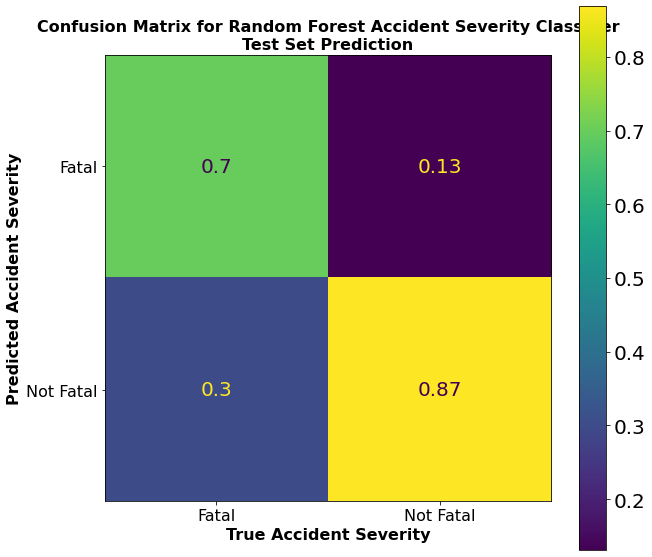

In [99]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Increase the font size for the values displayed inside the confusion matrix
plt.rc('font', **{'size':20})

# Setup the axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), squeeze=True)

# Plot the confusion matrix on the axis, using the estimator and test set
ConfusionMatrixDisplay.from_estimator(estimator=rs_severity_rf_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      normalize='pred', 
                                      ax=ax)

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("True Accident Severity", size=16, weight=1_000)
ax.set_ylabel("Predicted Accident Severity", size=16, weight=1_000)
ax.set_title("Confusion Matrix for Random Forest Accident Severity Classifier\nTest Set Prediction", size=16, weight=1_000);

#### KNN Accident Severity Classifier

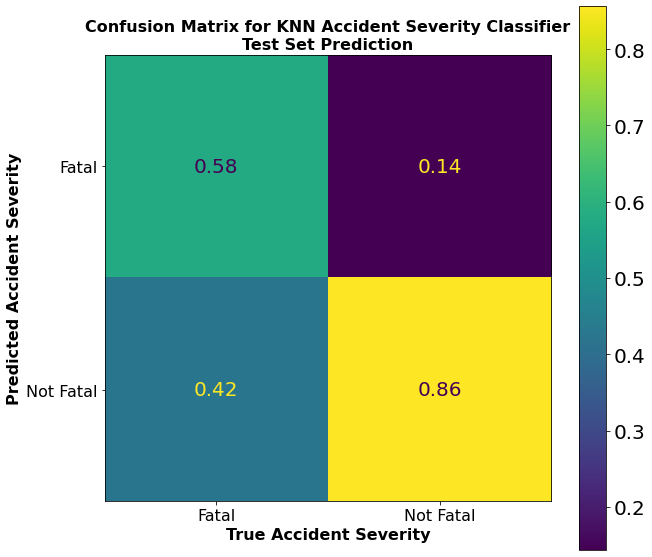

In [100]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Increase the font size for the values displayed inside the confusion matrix
plt.rc('font', **{'size':20})

# Setup the axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), squeeze=True)

# Plot the confusion matrix on the axis, using the estimator and test set
ConfusionMatrixDisplay.from_estimator(estimator=rs_severity_knn_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      normalize='pred', 
                                      ax=ax)

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("True Accident Severity", size=16, weight=1_000)
ax.set_ylabel("Predicted Accident Severity", size=16, weight=1_000)
ax.set_title("Confusion Matrix for KNN Accident Severity Classifier\nTest Set Prediction", size=16, weight=1_000);

## Age Regression

# Model and Evaluation 5
- Discuss the advantages of each model for each classification task, if any. 
- If there are not advantages, explain why. Is any model better than another? 
- Is the difference significant with 95% confidence? Use proper statistical comparison methods. 
- You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
(10)

## Accident Severity Classification

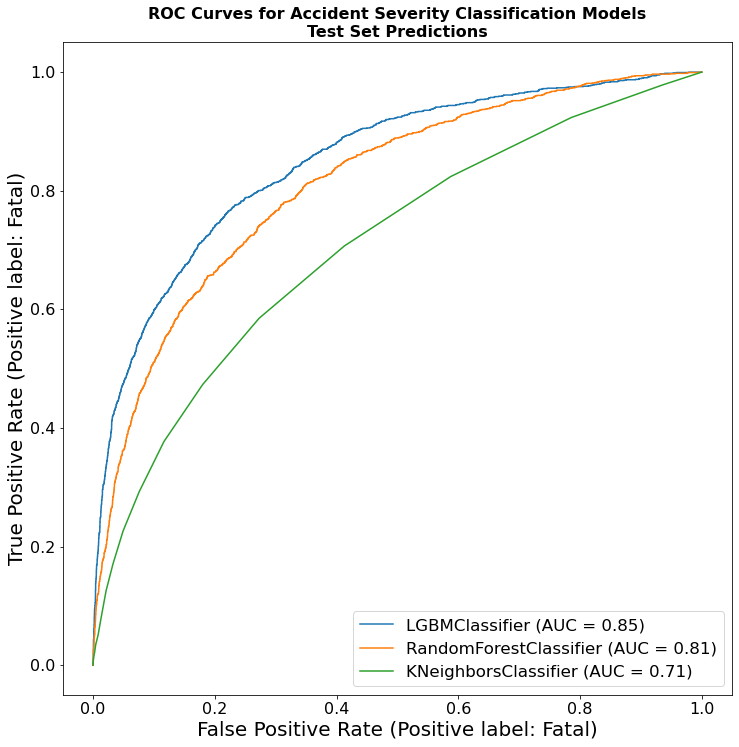

In [101]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]


# Setup the axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12), squeeze=True)

# Plot the ROC Curve for the LGBM Classifier
RocCurveDisplay.from_estimator(estimator=rs_severity_lgbm_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      ax=ax, pos_label="Fatal")

# Plot the ROC Curve for the RF Classifier
RocCurveDisplay.from_estimator(estimator=rs_severity_rf_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      ax=ax, pos_label="Fatal")

# Plot the ROC Curve for the KNN Classifier
RocCurveDisplay.from_estimator(estimator=rs_severity_knn_clf.best_estimator_, 
                                      X=X, 
                                      y=y, 
                                      ax=ax, pos_label="Fatal")

ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize="small")
ax.set_title("ROC Curves for Accident Severity Classification Models\nTest Set Predictions", size=16, weight=1_000);

In [ ]:
#Discuss the advantages of each model for each classification task, if any. 

#Advantages:
#- LightGBM does the best job of not assigning a low fatality probability to an actual fatal collision. If a system was built to utilize fatality probilities rather than classifications, assigning a low fatality probability to a fatal collision would be a costly mistake. 
#- Number of correct classifications and metrics (AUC and F1).
#- Discuss Fit and Predict Times?

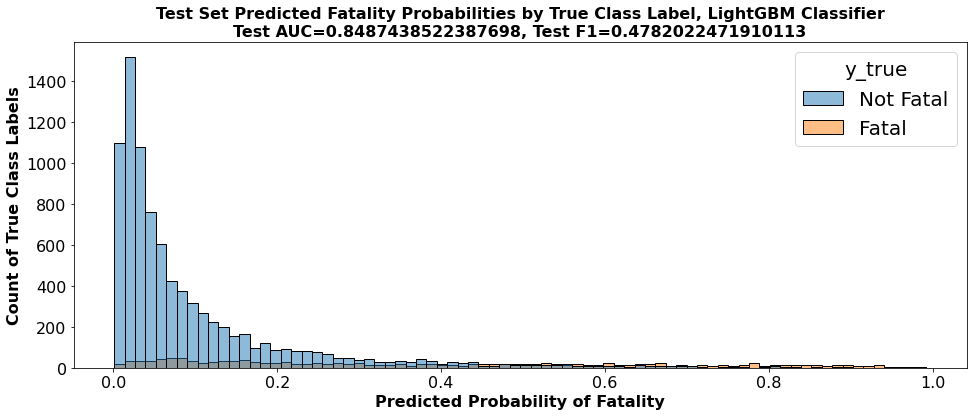

In [102]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Calculate the predicted classes for the test set
y_pred = rs_severity_lgbm_clf.predict(X)

# Calculate predicted class probabilities for the test set
predicted_probabilities = rs_severity_lgbm_clf.predict_proba(X)

# Create a dataframe containing true label, predicted label and class probabilities
lgbm_prediction_df = pd.DataFrame({"y_true":y, 
                                   "y_pred":y_pred, 
                                   "predicted_probability_fatal": predicted_probabilities[:,0], 
                                   "predicted_probability_not_fatal": predicted_probabilities[:,1]})

# Set up the axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), squeeze=True)

# Calculate test set AUC and F1
test_auc = roc_auc_score(y_true=y, y_score=predicted_probabilities[:,1])
test_f1 = f1_score(y_true=y, y_pred=y_pred, pos_label="Fatal")

# Plot the predicted probability of fatality for each true class label
sns.histplot(data=lgbm_prediction_df, 
             x="predicted_probability_fatal", 
             hue="y_true", 
             ax=ax);

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("Predicted Probability of Fatality", size=16, weight=1_000)
ax.set_ylabel("Count of True Class Labels", size=16, weight=1_000)
ax.set_title(f"Test Set Predicted Fatality Probabilities by True Class Label, LightGBM Classifier\nTest AUC={test_auc}, Test F1={test_f1}", size=16, weight=1_000);

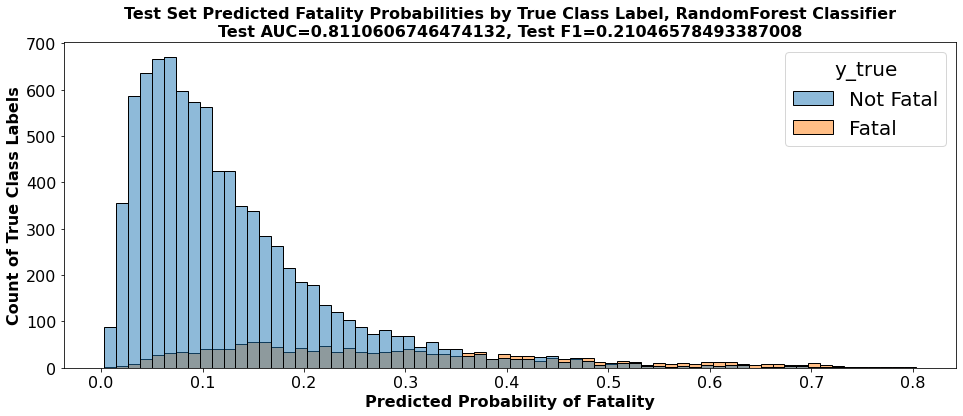

In [104]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

y_pred = rs_severity_rf_clf.predict(X)
predicted_probabilities = rs_severity_rf_clf.predict_proba(X)

rf_prediction_df = pd.DataFrame({"y_true":y, 
                                   "y_pred":y_pred, 
                                   "predicted_probability_fatal": predicted_probabilities[:,0], 
                                   "predicted_probability_not_fatal": predicted_probabilities[:,1]})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), squeeze=True)

test_auc = roc_auc_score(y_true=y, y_score=predicted_probabilities[:,1])
test_f1 = f1_score(y_true=y, y_pred=y_pred, pos_label="Fatal")

sns.histplot(data=rf_prediction_df, 
             x="predicted_probability_fatal", 
             hue="y_true", 
             ax=ax);

ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("Predicted Probability of Fatality", size=16, weight=1_000)
ax.set_ylabel("Count of True Class Labels", size=16, weight=1_000)
ax.set_title(f"Test Set Predicted Fatality Probabilities by True Class Label, RandomForest Classifier\nTest AUC={test_auc}, Test F1={test_f1}", size=16, weight=1_000);

In [106]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Predicted probabilities LightGBM gave to test set observations
predicted_probabilities = rs_severity_lgbm_clf.predict_proba(X)

# Calculate LightGBM AUC on test set
auc = roc_auc_score(y_true=y, y_score=predicted_probabilities[:,1])

# This link provides the formula for the standard error of an AUC value
# https://www.real-statistics.com/descriptive-statistics/roc-curve-classification-table/auc-confidence-interval/
n1 = len(y[y == "Not Fatal"])
n2 = len(y[y == "Fatal"])

se_auc_q0 = auc*(1 - auc)
se_auc_q1 = (auc / (2 - auc)) - auc**2
se_auc_q2 = ((2*(auc**2)) /  (1 + auc)) - auc**2

se_auc_lgbm = np.sqrt((se_auc_q0 + (n1 - 1)*se_auc_q1 + (n2-1)*se_auc_q2) / (n1*n2))

# This link provides the justification for the approximate normality of AUC scores (use of critical value from normal)
# https://stats.stackexchange.com/questions/214687/what-statistical-tests-to-compare-two-aucs-from-two-models-on-the-same-dataset
# Critical value for 95% confidence (two-tailed) from a standard normal distribution
z_critical = stats.norm.ppf(q=(0.975))

lgbm_auc_ci_lwr = auc - z_critical*se_auc_lgbm
lgbm_auc_ci_upr = auc + z_critical*se_auc_lgbm
lgbm_auc_center = auc

print("==========================================")
print("95% CI for LightGBM AUC")
print(f"Lower Limit: {lgbm_auc_ci_lwr}")
print(f"Best Estimate: {lgbm_auc_center}")
print(f"Upper Limit: {lgbm_auc_ci_upr}")
print("==========================================")

95% CI for LightGBM AUC
Lower Limit: 0.8403701831354359
Best Estimate: 0.8487438522387698
Upper Limit: 0.8571175213421037


In [107]:
# Split the test data into X and y
X = test_pp_df.drop(columns=["maxsev_binned"])
y = test_pp_df.loc[:, "maxsev_binned"]

# Predicted probabilities LightGBM gave to test set observations
predicted_probabilities = rs_severity_rf_clf.predict_proba(X)

# Calculate LightGBM AUC on test set
auc = roc_auc_score(y_true=y, y_score=predicted_probabilities[:,1])

# This link provides the formula for the standard error of an AUC value
# https://www.real-statistics.com/descriptive-statistics/roc-curve-classification-table/auc-confidence-interval/
n1 = len(y[y == "Not Fatal"])
n2 = len(y[y == "Fatal"])

se_auc_q0 = auc*(1 - auc)
se_auc_q1 = (auc / (2 - auc)) - auc**2
se_auc_q2 = ((2*(auc**2)) /  (1 + auc)) - auc**2

se_auc_rf= np.sqrt((se_auc_q0 + (n1 - 1)*se_auc_q1 + (n2-1)*se_auc_q2) / (n1*n2))

# This link provides the justification for the approximate normality of AUC scores (use of critical value from normal)
# https://stats.stackexchange.com/questions/214687/what-statistical-tests-to-compare-two-aucs-from-two-models-on-the-same-dataset
# Critical value for 95% confidence (two-tailed) from a standard normal distribution
z_critical = stats.norm.ppf(q=(0.975))

rf_auc_ci_lwr = auc - z_critical*se_auc_lgbm
rf_auc_ci_upr = auc + z_critical*se_auc_lgbm
rf_auc_center = auc

print("==========================================")
print("95% CI for Random Forest AUC")
print(f"Lower Limit: {rf_auc_ci_lwr}")
print(f"Best Estimate: {rf_auc_center}")
print(f"Upper Limit: {rf_auc_ci_upr}")
print("==========================================")

95% CI for Random Forest AUC
Lower Limit: 0.8026870055440792
Best Estimate: 0.8110606746474132
Upper Limit: 0.8194343437507471


In [108]:
# Null: LightGBM AUC = Random Forest AUC
# Alt: LightGBM Auc != Random Forest AUC

# Test Statistic: Z_test = (lgbm_auc - rf_auc) / SE(lgbm_auc)
difference_in_aucs = lgbm_auc_center - rf_auc_center
z_test = difference_in_aucs / se_auc_lgbm

# norm.sf = 1 - CDF, giving the probability an value from a normal distribution is greater than z_test
# Since this is a two tailed test, the p-value is 2*(Probability of being greater than Z_test)
p_value = stats.norm.sf(z_test)*2

print("==========================================")
print("NULL: LGBM AUC = RF AUC")
print("ALT: LGBM AUC != RF AUC\n")
print(f"Best Estimate AUC, LGBM: {lgbm_auc_center}")
print(f"Best Estimate AUC, RF: {rf_auc_center}")
print(f"Difference in AUCs: {difference_in_aucs}")
print(f"Standard Error AUC, LGBM: {se_auc_lgbm}\n")
print("Using alpha=0.05, two tails, and standard normal dist.")
print(f"Test Statistic: {z_test}")
print(f"P-Value: {p_value}")
print("==========================================")

# Conclusion: We reject the null hypothesis and conclude that there is significant evidence at the alpha=0.05 level that the lgbm_auc is not equal to the rf_auc
#             Further, since lgbm_auc > rf_auc, we conclude there is significant evidence that the lgbm_auc is greater than the rf_auc (pvalue = 1.142*10^-18)

NULL: LGBM AUC = RF AUC
ALT: LGBM AUC != RF AUC

Best Estimate AUC, LGBM: 0.8487438522387698
Best Estimate AUC, RF: 0.8110606746474132
Difference in AUCs: 0.03768317759135664
Standard Error AUC, LGBM: 0.004272358660355152

Using alpha=0.05, two tails, and standard normal dist.
Test Statistic: 8.820228025571272
P-Value: 1.1422686821430145e-18


## Age Regression

# Model and Evaluation 6 
- Which attributes from your analysis are most important? 
- Use proper methods discussed in class to evaluate the importance of different attributes. 
- Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.
(10)

## Accident Severity Classification

## Age Regression

# Deployment
(5)

## Task 1: Accident Severity Classification
1. How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?

    The goal of this model is to understand how accident severity is associated with crash factors. Interested parties may be able to use this model to predict fatal accidents in real time. Historical data can be used to identify high-risk areas or times to predict future fatal accidents.

2. How would you measure the model's value if it was used by these parties?

    The model would be successful if provided a basis for change to road infrastructure or policies and general public awareness.

3. How would your deploy your model for interested parties?

    The model could be deployed as a risk map to visualize crash density in the US.

4. What other data should be collected? How often would the model need to be updated, etc.?

    GPS data could be collected to obtain a more granular understanding of at-risk locations. The model would ideally be updated as new traffic information comes in but is perhaps at the mercy of memory and computational power.

## Task 1: Age Regression
1. How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?

    This model is used for multivariate **inference**, notably to assess effect of age on crash involvement and fatality. 

2. How would you measure the model's value if it was used by these parties?

    The model would be successful if it acted as foundational base for public awareness and policy changes. 

3. How would your deploy your model for interested parties?

    Model deployment would be in some visual form, perhabs on Tableau for leadership and public consumption.

4. What other data should be collected? How often would the model need to be updated, etc.?

    Additional location, traffic, or accident data could be collected in conjunction. Because this is an inferential model, it does not need to be updated as often, though on a quarterly basis is ideal.

# Exceptional Work
- You have free reign to provide additional analyses. 
- One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. 
- Which parameters are most significant for making a good model for each classification algorithm?
(10)

In [ ]:
# grid search code

# Appendix
Data dictionary referenced from [CRSS Analytical Users Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813236)